# Import

In [1]:
from utils import *
from modules import *
import numpy as np 
import pandas as pd
from PIL import Image
import os
from os import listdir
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import rand_score,adjusted_rand_score
from sklearn.decomposition import PCA
from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore")

# Fonctions

In [10]:
def evaluation(datas,labels,verbose=False):
    titles = ["X","Representation Latente","X_hat"]
    scores = []
    puritities = []
    rand_scores= []
    for i,data in enumerate(datas):

        shape = data.shape[1]
        nb_classes = len(np.unique(labels))

        neuro_i_1 = shape
        neuro_o_1 = shape // 2
        neuro_i_2 = shape // 2
        neuro_o_2 = shape // 4
        neuro_i_3 = shape // 4
        neuro_o_3 = nb_classes
        facteur_norma = 0.4
        plage_biais = (0,1)
        batch_size = 100
        epochs = 50


        facteur_norma = 0.8
        lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
        lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
        lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init=1)
        TanH = ModuleTanH()
        sigmoide = ModuleSigmoide()
        mseloss = MSELoss()
        CE = CrossEntropieLoss(nb_classes)
        softmax = SoftMax()


        network_layers = [lineaire_1,TanH,lineaire_2,TanH,lineaire_3,softmax]
        network = Sequentiel(network_layers)

        if verbose : print("Optimisation de : ",titles[i])
        opti = Optim(network,CE,1e-2)
        opti.SGD(data,labels,batch_size,epochs)

        score = opti.getNetwork().accuracy(data,labels) 
        scores.append(score)
        if verbose : print("Accuracy sur les images issues de l'auto encodeur",score)    
        
        kmeans = KMeans(n_clusters=10, random_state=0, max_iter=1000).fit(data)
        yhat = kmeans.labels_
        
        purete = cluster_purity(yhat,labels)
        puritities.append(purete)
        
        rs  = rand_score(yhat,labels)
        rand_scores.append(rs)
        
        if verbose : 
            print("Pureté du clustering : ",purete)
            print("Rand score  : ",rs)
            print("Adjusted Rand Score : ",adjusted_rand_score(yhat,labels))
            print()

        
        
    return scores,puritities,rand_scores
        
        
        
def optimisation_espace_latent(data,labels,dim_espace_latent_list,eps,verbose=False):
    
    nb_classes = len(np.unique(labels))
    n_samples = data.shape[0]
    scores = []
    puritities = []
    rand_scores= []
    
    
    for dim_espace_latent in dim_espace_latent_list:
        

        neuro_i_1 = 256
        neuro_o_1 = 160
        neuro_i_2 = 160
        neuro_o_2 = 120
        neuro_i_3 = 120
        neuro_o_3 = 60
        neuro_i_4 = 60
        neuro_o_4 = dim_espace_latent
        
        facteur_norma = 0.4
        plage_biais = (0,1)
        batch_size = 100
        epochs = 100
        nb_couches = 4


        facteur_norma = 0.8


        lineaire_1_enc = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
        lineaire_2_enc = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
        lineaire_3_enc = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init=1)
        lineaire_4_enc = ModuleLineaire(neuro_i_4 ,neuro_o_4 ,plage_biais,facteur_norma,init=1)

        lineaire_1_dec = ModuleLineaire(neuro_o_1 ,neuro_i_1 ,plage_biais,facteur_norma,init=1)
        lineaire_2_dec = ModuleLineaire(neuro_o_2 ,neuro_i_2 ,plage_biais,facteur_norma,init=1)
        lineaire_3_dec = ModuleLineaire(neuro_o_3 ,neuro_i_3 ,plage_biais,facteur_norma,init=1)
        lineaire_4_dec = ModuleLineaire(neuro_o_4 ,neuro_i_4 ,plage_biais,facteur_norma,init=1)

        TanH = ModuleTanH()
        sigmoide = ModuleSigmoide()
        BCE = BinaryCrossEntropie()


        network_layers = [lineaire_1_enc,TanH,lineaire_2_enc,TanH,lineaire_3_enc,TanH,lineaire_4_enc,TanH,
                          lineaire_4_dec,TanH,lineaire_3_dec,TanH,lineaire_2_dec,TanH,lineaire_1_dec,sigmoide]
        network = Sequentiel(network_layers)

        auto_encodeur_usps = AutoEncodeur(network,BCE)

        
        if verbose : print("Dimension espace latent : ",dim_espace_latent)
        
        auto_encodeur_usps.optimisation(data,labels,batch_size,epochs,eps,False)
        
        
        
        latent_repre = auto_encodeur_usps.encode(data)
        
        datas = [latent_repre]
        score,purete,rand_score = evaluation(datas,labels,verbose)
        scores.append(score)
        puritities.append(purete)
        rand_scores.append(rand_score)
        
    return scores , puritities , rand_scores



def create_auto_encodeur(X_train,output_dim, nb_couche_lin,activations, facteur_norma, plage_biais, batch_size, epochs,eps=1e-4):
    np.random.seed(42)
    input_dim = X_train.shape[1]
    n_samples = X_train.shape[0]
    neuro_in = [input_dim]
    neuro_out = []
    activations_enc = activations[0]
    activations_dec = activations[1]
    assert len(activations_enc) == nb_couche_lin and len(activations_dec) == nb_couche_lin
    for i in range(0,nb_couche_lin) : 
        neuro_out.append(neuro_in[::-1][0] // 2)
        neuro_in.append(neuro_out[::-1][0])
    neuro_out[-1] = output_dim
    neuro_in = neuro_in [:-1]
    modules_enc = []
    for i in range(nb_couche_lin):
        modules_enc.append(ModuleLineaire(neuro_in[i], neuro_out[i], plage_biais, facteur_norma, init=1))
        modules_enc.append(activations_enc[i])
        

    modules_dec = []
    #neuro_out = neuro_out[::-1]
    neuro_in = neuro_in[::-1]
    neuro_out = neuro_out[::-1]
    for i in range(nb_couche_lin):
        modules_dec.append(ModuleLineaire(neuro_out[i], neuro_in[i], plage_biais, facteur_norma, init=1))
        modules_dec.append(activations_dec[i])
        
    
    network = Sequentiel(modules_enc + modules_dec)
    BCE = BinaryCrossEntropie()
    auto_encodeur_usps = AutoEncodeur(network, BCE)
    auto_encodeur_usps.optimisation(X_train, X_train, batch_size, epochs,eps)
    
    return auto_encodeur_usps




def optimisation_nb_layers(X_train,Y_train,liste_layers,output_dim,facteur_norma,plage_biais,batch_size,epochs,random_activ):
    shape = X_train.shape[1]
    TanH = ModuleTanH()
    sigmoide = ModuleSigmoide()
    activ = np.array([TanH,sigmoide])
    scores = []
    act_s = []
    opt_s = []
    
    
  
    for nb_layer in liste_layers:
        print("Optimisation nb_layer  : ",nb_layer)
        
        if random_activ:
            np.random.seed(42)
            activations_enc = np.random.randint(0,2,size=nb_layer)
            activations_dec = np.random.randint(0,2,size=nb_layer)

            activ_enc = activ[activations_enc]
            activ_dec = activ[activations_dec]

            activ_layer = [activ_enc,activ_dec]
        else:
            activations_enc = [TanH for _ in range(nb_layer)]
            activations_dec = [TanH for _ in range(nb_layer - 1)]
            activations_dec.append(sigmoide)
            activ_layer = [activations_enc,activations_dec]
        
        opt = create_auto_encodeur(X_train,output_dim, nb_layer,activ_layer, facteur_norma, plage_biais, batch_size, epochs,eps=1e-4)
        
        latent_repre = opt.encode(X_train)
        X_train_hat = opt.decode(latent_repre)
        
        scores.append(evaluation([X_train_hat],Y_train)[0])
        act_s.append(activ_layer)
        opt_s.append(opt)
        
        
    return scores,act_s,opt_s




def optimisation_network(X_train,Y_train,X_test,Y_test,liste_layers,liste_dim_espace_latent,batch_size,epochs,random_activ=False,verbose=False):
    
    facteur_norma = 0.8
    plage_biais = (0,1)
    resultat_train = {}
    scores_test = []
    for output_dim in liste_dim_espace_latent :
        print("Optimisation de la dimension de l'espace latent : ",output_dim)
        resultat_train["Espace latent " +str(output_dim)] = optimisation_nb_layers(X_train,Y_train,liste_layers,output_dim,facteur_norma,plage_biais,batch_size,epochs,random_activ)
        print()
        l = []
        for i,nb_layer in enumerate(liste_layers):
            opt = resultat_train['Espace latent '+str(output_dim)][2][i]
            latent_repre = opt.encode(X_test)
            X_test_hat = opt.decode(latent_repre)

            l.append(evaluation([X_test_hat],Y_test)[0])
        scores_test.append(l)
    
    LDS = ["LD"+str(output_dim) for output_dim in liste_dim_espace_latent]
    
    if verbose:
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        for i, output_dim in enumerate(liste_dim_espace_latent) :
            
            scores = resultat_train['Espace latent '+str(output_dim)][0]
            plt.title("Accuracy du train selon l'espace latent ")
            plt.xlabel("nombre de layers")
            plt.ylabel("accuracy")
            plt.plot(liste_layers,scores)
        plt.legend(LDS)
        
        
        plt.subplot(1,2,2)
            
        for i, output_dim in enumerate(liste_dim_espace_latent) :

            activs = resultat_train['Espace latent '+str(output_dim)][1]
            plt.title("Accuracy du train selon l'espace latent")
            plt.xlabel("nombre de layers")
            plt.ylabel("accuracy")
            plt.plot(liste_layers,scores_test[i])

        plt.legend(LDS)

        plt.show()
        
        
    maximums = []
    for i, output_dim in enumerate(liste_dim_espace_latent) :
        
        scores , activations ,_ = resultat_train['Espace latent '+str(output_dim)]
        maximums.append(np.max(scores))
        
    
    dim_espace_latent_optimal = liste_dim_espace_latent[np.argmax(maximums)]
    scores = resultat_train['Espace latent '+str(dim_espace_latent_optimal)][0]
    nb_layer_optimal = liste_layers[np.argmax(scores)]
    nb_layer_optimal_ind = np.argmax(scores)
    activ_optimal = resultat_train['Espace latent '+str(dim_espace_latent_optimal)][1][nb_layer_optimal_ind]
    
    network_optimal = create_auto_encodeur(X_train,dim_espace_latent_optimal, nb_layer_optimal,activ_optimal, facteur_norma, plage_biais, batch_size, epochs)
    
    print("Auto encodeur optimal : ")
    print("Nombre layer optimal : ",nb_layer_optimal)
    print("Dimension optimale de l'espace latent : ",dim_espace_latent_optimal)
    print("Fonctions d'activation prises : ")
    print([str(a) for a in activ_optimal[0]])
    print([str(a) for a in activ_optimal[1]])
    
    return network_optimal


# Probleme Lineaire

### Probleme lineaire dont la frontiere de decision va passer par l'origine

In [20]:
# definir un jeu de données lineairement separable 
seed = 42
np.random.seed(seed)
pos_cen = (-3, -3)
pos_sig = [[1, 4], [4, 1]]

neg_cen = (3, 3)
neg_sig = [[1, 5], [4, 1]]
data_train,labels_train = genere_dataset_gaussian(pos_cen,pos_sig,neg_cen,neg_sig,100,-1,1)
labels_train = labels_train.reshape(-1,1)

pos_cen = (-3, -3)
pos_sig = [[2, 2], [3, 2]]

neg_cen = (3, 3)
neg_sig = [[1, 2], [4, 2]]
data_test,labels_test = genere_dataset_gaussian(pos_cen,pos_sig,neg_cen,neg_sig,100,-1,1)
labels_test = labels_test.reshape(-1,1)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1151.55it/s]


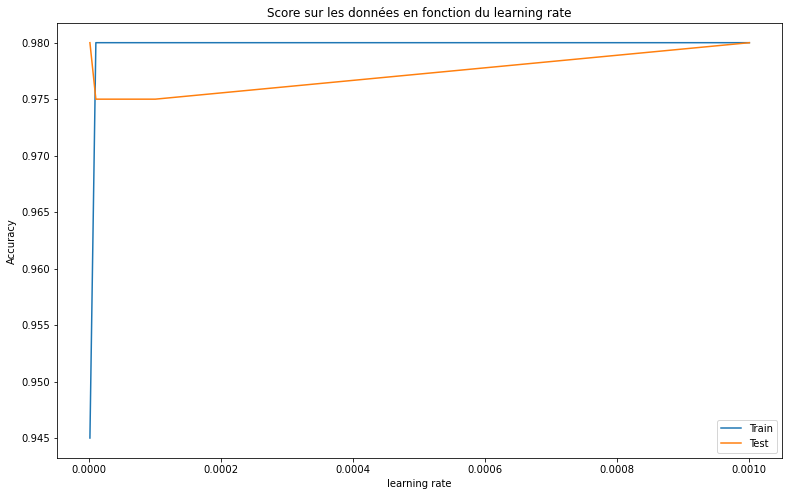

Learning rate optimal  :  0.001


In [41]:
# definir un reseau linaire
facteur_norma = 0.4
plage_biais = (0,1)
np.random.seed(96)

neuro_i = 2
neuro_o = 1
batch_size = 20
epochs = 1000
rates = np.array([1e-3,1e-4,1e-5,1e-6])
scores_tr = []
scores_te = []

for eps in rates:

    lineaire = ModuleLineaire(neuro_i,neuro_o,plage_biais,facteur_norma,init=1)
    mseloss = MSELoss()
    network_layers = [lineaire]
    network = Sequentiel(network_layers)

    opti = Optim(network,mseloss,eps)
    opti.SGD(data,labels,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(data_train,labels_train))
    scores_te.append(opti.getNetwork().accuracy(data_test,labels_test))
    
plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction du learning rate")
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.plot(rates,scores_tr)
plt.plot(rates,scores_te)
plt.legend(["Train","Test"])
plt.show()

eps_optimal = rates[np.argmax(scores_te)]
print("Learning rate optimal  : ",eps_optimal)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 874.28it/s]


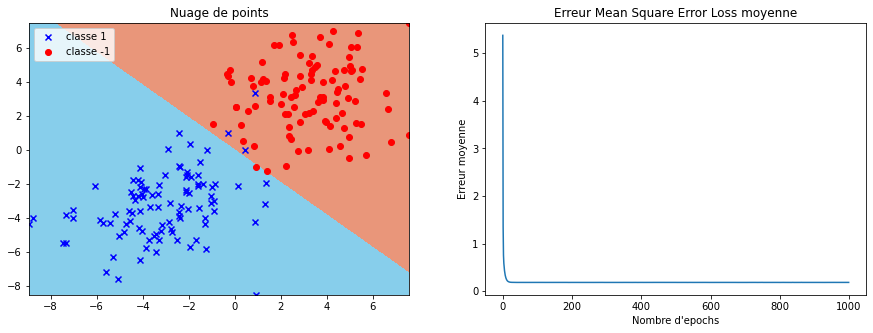

Accuracy  :  0.98


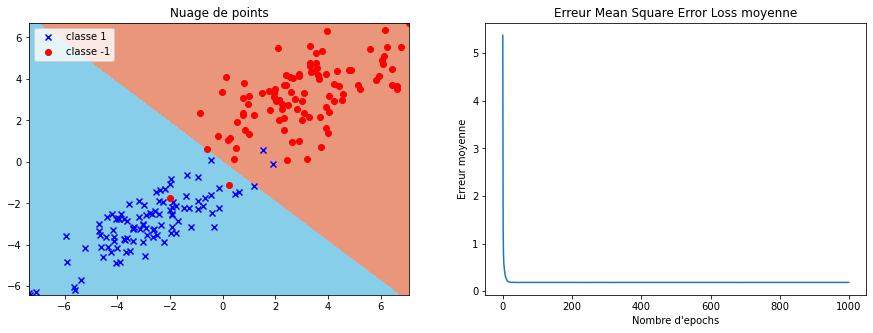

Accuracy  :  0.975


In [42]:
# definir un reseau linaire
facteur_norma = 0.4
plage_biais = (0,1)
neuro_i = 2
neuro_o = 1
batch_size = 20
epochs = 1000

lineaire = ModuleLineaire(neuro_i,neuro_o,plage_biais,facteur_norma,init=1)
mseloss = MSELoss()
network_layers = [lineaire]
network = Sequentiel(network_layers)

opti = Optim(network,mseloss,1e-4)
opti.SGD(data_train,labels_train,batch_size,epochs)
opti.affichage(data_train,labels_train)

opti.affichage(data_test,labels_test)

### Probleme lineaire separable uniquement avec introduction du biais

In [52]:
# definir un jeu de données lineairement separable 
seed = 42
np.random.seed(seed)
pos_cen = (3, 3)
pos_sig = [[1, 16], [16, 1]]

neg_cen = (13, 13)
neg_sig = [[1, 15], [16, 1]]
data_train,labels_train = genere_dataset_gaussian(pos_cen,pos_sig,neg_cen,neg_sig,100,-1,1)
labels_train = labels_train.reshape(-1,1)


pos_cen = (3, 3)
pos_sig = [[2, 14], [16, 3]]
neg_cen = (13, 13)
neg_sig = [[1, 13], [17, 2]]
data_test,labels_test = genere_dataset_gaussian(pos_cen,pos_sig,neg_cen,neg_sig,100,-1,1)
labels_test = labels_test.reshape(-1,1)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2563.30it/s]


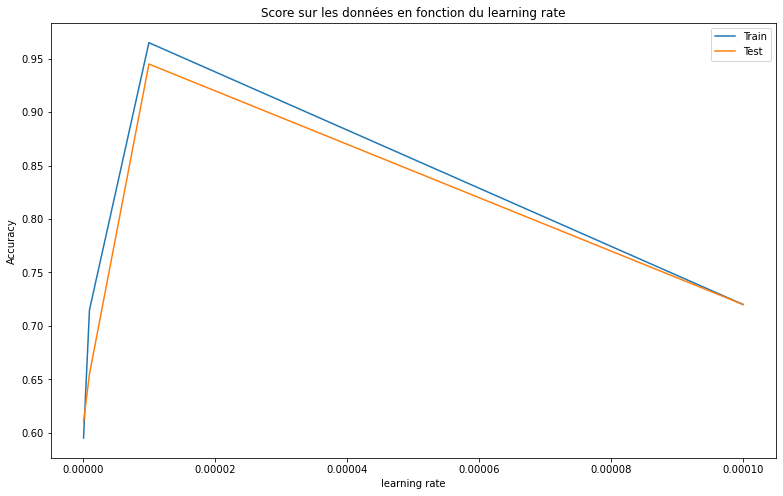

Learning rate optimal  :  1e-05


In [56]:
# definir un reseau linaire
np.random.seed(96)
facteur_norma = 0.4
plage_biais = (0,1)
neuro_i = 2
neuro_o = 1
batch_size = 50
epochs = 1000
rates = np.array([1e-4,1e-5,1e-6,1e-7])
scores_tr = []
scores_te = []

for eps in rates:

    lineaire = ModuleLineaire(neuro_i,neuro_o,plage_biais,facteur_norma,init=1)
    mseloss = MSELoss()
    network_layers = [lineaire]
    network = Sequentiel(network_layers)

    opti = Optim(network,mseloss,eps)
    opti.SGD(data_train,labels_train,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(data_train,labels_train))
    scores_te.append(opti.getNetwork().accuracy(data_test,labels_test))

plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction du learning rate")
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.plot(rates,scores_tr)
plt.plot(rates,scores_te)
plt.legend(["Train","Test"])
plt.show()

eps_optimal = rates[np.argmax(scores_te)]
print("Learning rate optimal  : ",eps_optimal)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 993.63it/s]


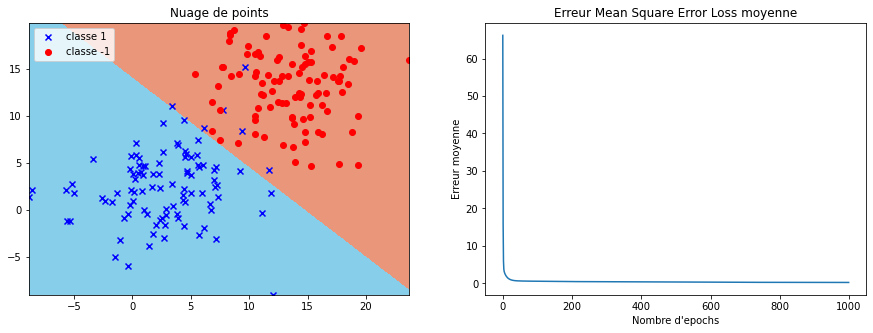

Accuracy  :  0.97


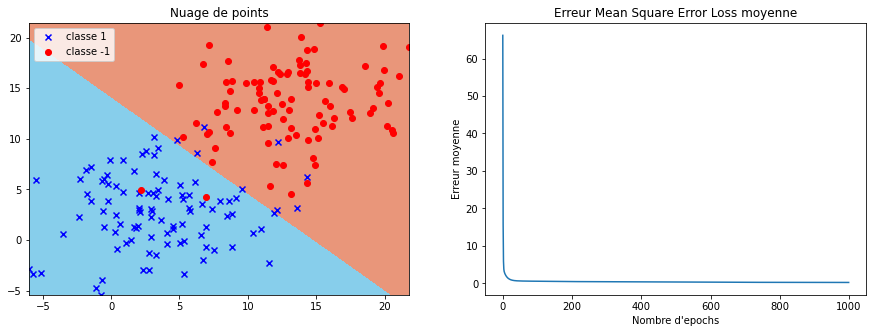

Accuracy  :  0.945


In [57]:
# definir un reseau linaire
facteur_norma = 0.4
plage_biais = (0,1)
neuro_i = 2
neuro_o = 1
batch_size = 20
epochs = 1000

lineaire = ModuleLineaire(neuro_i,neuro_o,plage_biais,facteur_norma,init=1)
mseloss = MSELoss()
network_layers = [lineaire]
network = Sequentiel(network_layers)

opti = Optim(network,mseloss,eps_optimal)
opti.SGD(data_train,labels_train,batch_size,epochs)
opti.affichage(data_train,labels_train)

opti.affichage(data_test,labels_test)

# Non Lineaire

### Definir un jeu de données de type XOR qui non separable lineairement 

In [60]:
# definir un jeu de données XOR

seed = 42
np.random.seed(seed)
data_xor_train , labels_xor_train = create_XOR(200,0.2)

data_xor_test , labels_xor_test = create_XOR(200,0.3)

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 340.13it/s]


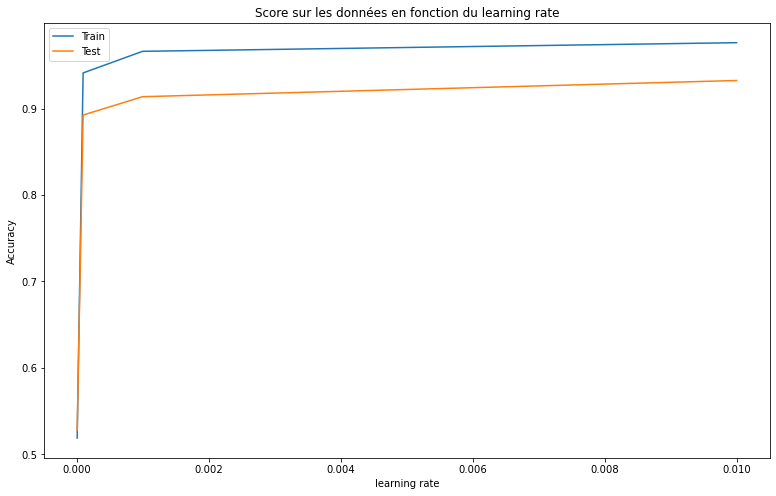

Learning rate optimal  :  0.01


In [61]:
neuro_i_1 = 2
neuro_o_1 = 4
neuro_i_2 = 4
neuro_o_2 = 1

plage_biais = (0,1)
batch_size = 50
epochs = 1000
facteur_norma = 0.8

rates = np.array([1e-2,1e-3,1e-4,1e-5])
scores_tr = []
scores_te = []

for eps in rates:
    lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
    lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
    TanH = ModuleTanH()
    sigmoide = ModuleSigmoide()
    mseloss = MSELoss()


    network_layers = [lineaire_1,TanH,lineaire_2,sigmoide]
    network = Sequentiel(network_layers)


    opti = Optim(network,mseloss,eps)
    opti.SGD(data_xor_train,labels_xor_train,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(data_xor_train,labels_xor_train))
    scores_te.append(opti.getNetwork().accuracy(data_xor_test,labels_xor_test))

plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction du learning rate")
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.plot(rates,scores_tr)
plt.plot(rates,scores_te)
plt.legend(["Train","Test"])
plt.show()

eps_optimal = rates[np.argmax(scores_te)]
print("Learning rate optimal  : ",eps_optimal)

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 357.91it/s]


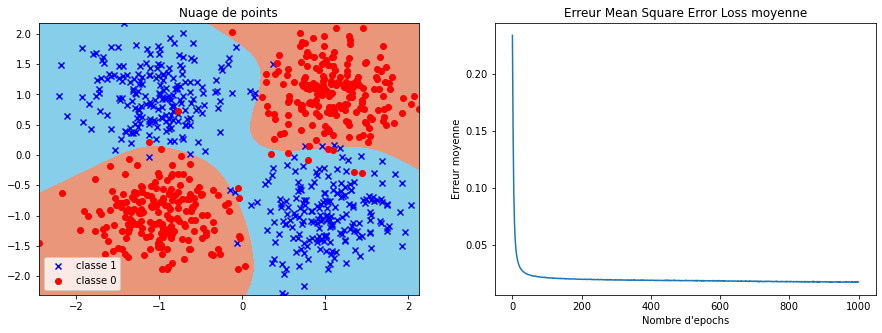

Accuracy  :  0.97625


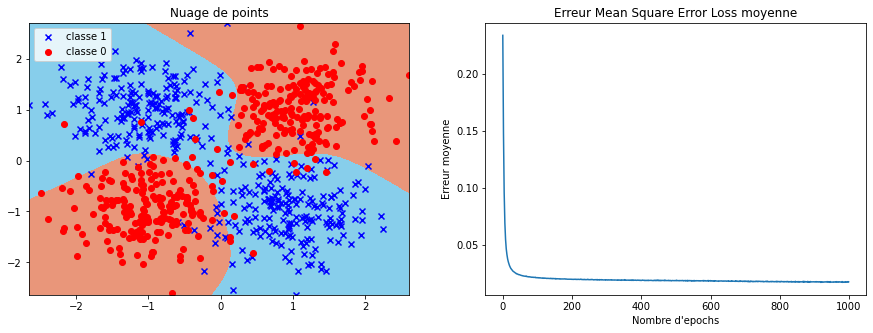

Accuracy  :  0.9325


In [63]:
neuro_i_1 = 2
neuro_o_1 = 4
neuro_i_2 = 4
neuro_o_2 = 1
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 1000


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()


network_layers = [lineaire_1,TanH,lineaire_2,sigmoide]
network = Sequentiel(network_layers)


opti = Optim(network,mseloss,eps_optimal)
opti.SGD(data_xor_train,labels_xor_train,batch_size,epochs)
opti.affichage(data_xor_train,labels_xor_train)
opti.affichage(data_xor_test,labels_xor_test)

### Definir un jeu de données de type DIRAC qui non separable lineairement 

In [69]:
# definir un jeu de données XOR

seed = 42
np.random.seed(seed)
data_dirac_train , label_dirac_train = create_data_dirac(200,0.1)
data_dirac_test , label_dirac_test = create_data_dirac(200,0.2)

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 229.04it/s]


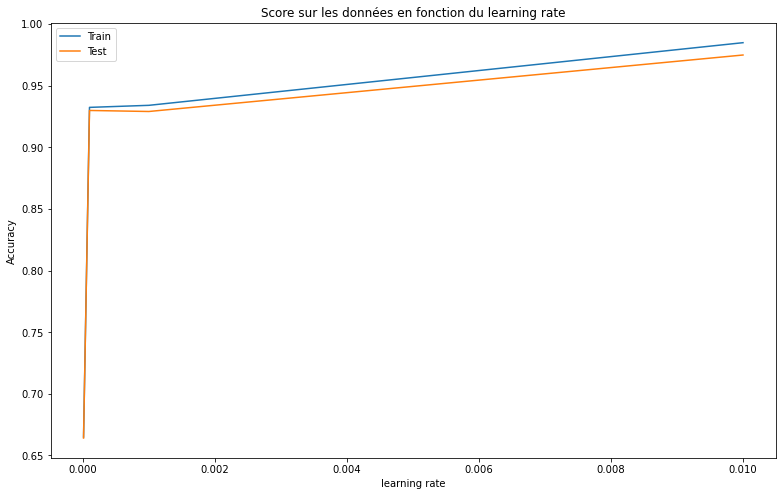

Learning rate optimal  :  0.01


In [66]:
neuro_i_1 = 2
neuro_o_1 = 4
neuro_i_2 = 4
neuro_o_2 = 1

plage_biais = (-1,10)
batch_size = 50
epochs = 1000
facteur_norma = 0.8

rates = np.array([1e-2,1e-3,1e-4,1e-5])

scores_tr = []
scores_te = []

for eps in rates:
    lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
    lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
    TanH = ModuleTanH()
    sigmoide = ModuleSigmoide()
    mseloss = MSELoss()


    network_layers = [lineaire_1,TanH,lineaire_2,sigmoide]
    network = Sequentiel(network_layers)


    opti = Optim(network,mseloss,eps)
    opti.SGD(data_dirac_train,label_dirac_train,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(data_dirac_train,label_dirac_train))
    scores_te.append(opti.getNetwork().accuracy(data_dirac_test,label_dirac_test))

plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction du learning rate")
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.plot(rates,scores_tr)
plt.plot(rates,scores_te)
plt.legend(["Train","Test"])
plt.show()

eps_optimal = rates[np.argmax(scores_te)]
print("Learning rate optimal  : ",eps_optimal)

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 239.48it/s]


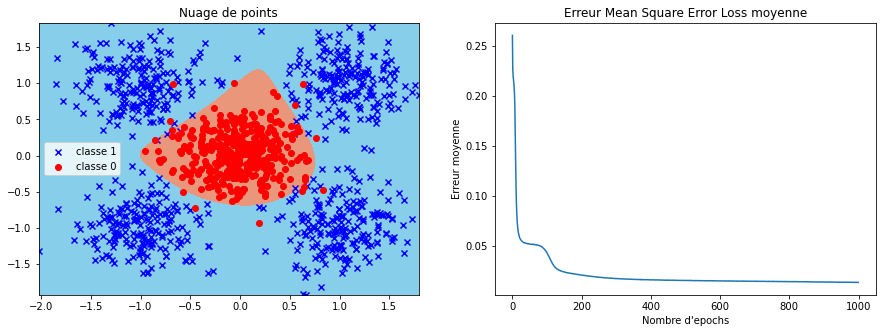

Accuracy  :  0.985


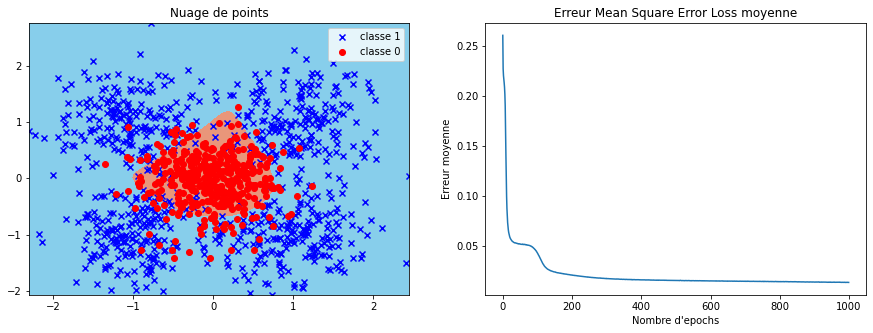

Accuracy  :  0.9016666666666666


In [70]:
neuro_i_1 = 2
neuro_o_1 = 4
neuro_i_2 = 4
neuro_o_2 = 1
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 1000


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()


network_layers = [lineaire_1,TanH,lineaire_2,sigmoide]
network = Sequentiel(network_layers)


opti = Optim(network,mseloss,eps_optimal)
opti.SGD(data_dirac_train,label_dirac_train,batch_size,epochs)
opti.affichage(data_dirac_train,label_dirac_train)
opti.affichage(data_dirac_test,label_dirac_test)

# Multi Classes

### import des données USPS

In [6]:
import pickle as pkl
data = pkl.load(open("data/usps.pkl",'rb'))

X_train = data["X_train"]
Y_train = data["Y_train"]
X_test = data["X_test"]
Y_test = data["Y_test"]

### Affichage en t-SNE des données

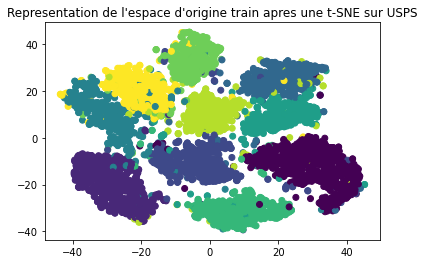

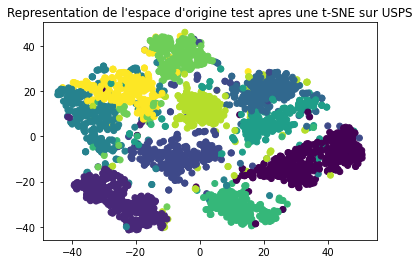

In [83]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)


repre_2D = tsne.fit_transform(X_train)

plt.figure(figsize=(13,8))
plt.title("Representation de l'espace d'origine train apres une t-SNE sur USPS")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)
plt.show()

repre_2D = tsne.fit_transform(X_test)

plt.figure(figsize=(13,8))
plt.title("Representation de l'espace d'origine test apres une t-SNE sur USPS")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_test)
plt.show()

### definition d'une architecture 

100%|███████████████████████████████████████████| 50/50 [00:35<00:00,  1.40it/s]


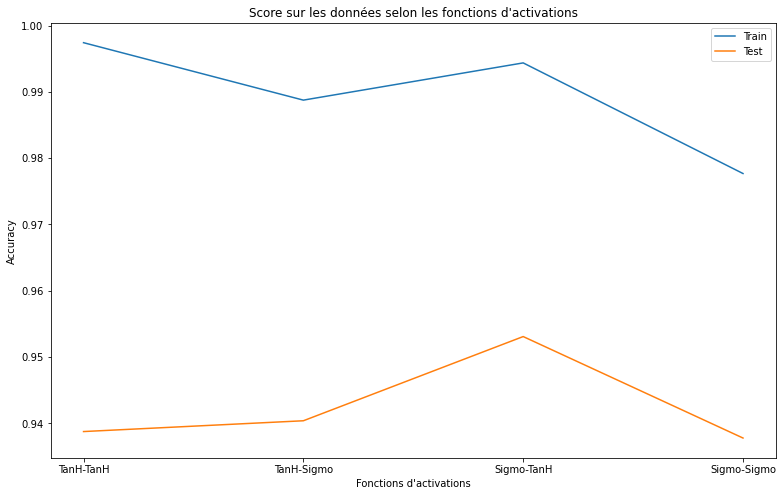

In [94]:
np.random.seed(42)
nb_classes = len(np.unique(Y_train))
n_samples = X_train.shape[0]

neuro_i_1 = 256
neuro_o_1 = 120
neuro_i_2 = 120
neuro_o_2 = 60
neuro_i_3 = 60
neuro_o_3 = 10
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 20
epochs = 50

scores_tr = []
scores_te = []
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()
CE = CrossEntropieLoss(nb_classes)
softmax = SoftMax()
activations = [[TanH,TanH],[TanH,sigmoide],[sigmoide,TanH],[sigmoide,sigmoide]]
fonctions = ["TanH-TanH","TanH-Sigmo","Sigmo-TanH","Sigmo-Sigmo"]

for activa in activations:
    lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
    lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
    lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init=1)

    network_layers = [lineaire_1,activa[0],lineaire_2,activa[1],lineaire_3,softmax]
    network = Sequentiel(network_layers)

    opti = Optim(network,CE,1e-2)
    opti.SGD(X_train,Y_train,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(X_train,Y_train))
    scores_te.append(opti.getNetwork().accuracy(X_test,Y_test)) 
    
    
plt.figure(figsize=(13,8))
plt.title("Score sur les données selon les fonctions d'activations")
plt.xlabel("Fonctions d'activations")
plt.ylabel("Accuracy")
plt.plot(fonctions,scores_tr)
plt.plot(fonctions,scores_te)
plt.legend(["Train","Test"])
plt.show()

- On remarque qu'en mettant une sigmoide pour la premiere couche et une autre sigmoide pour la deuxieme couche donne des resultats plus interessants vu que la generalisation sur le probleme est plus grande (97% train , 93% test) par rapport aux autres combinaisons de fonction d'activations.

### Evaluation du reseau optimal

100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.74it/s]


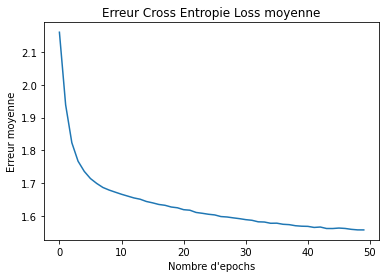

Accuracy  :  0.9733504575373254
Accuracy sur le train :  0.9733504575373254
Accuracy sur le test :  0.9341805148256761


In [99]:
np.random.seed(42)
nb_classes = len(np.unique(Y_train))
n_samples = X_train.shape[0]

neuro_i_1 = 256
neuro_o_1 = 120
neuro_i_2 = 120
neuro_o_2 = 60
neuro_i_3 = 60
neuro_o_3 = 10
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 50


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init=1)
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init=1)
lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init=1)
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()
CE = CrossEntropieLoss(nb_classes)
softmax = SoftMax()


network_layers = [lineaire_1,sigmoide,lineaire_2,sigmoide,lineaire_3,softmax]
network = Sequentiel(network_layers)

opti = Optim(network,CE,1e-2)
opti.SGD(X_train,Y_train,batch_size,epochs)
opti.affichage(X_train,Y_train)


print("Accuracy sur le train : ",opti.getNetwork().accuracy(X_train,Y_train))
print("Accuracy sur le test : ",opti.getNetwork().accuracy(X_test,Y_test))

In [110]:
Y_pred = opti.getNetwork().predict(X_train,nb_classes)

kmeans = KMeans(n_clusters=10, random_state=0, max_iter=1000).fit(X_train)
yhat = kmeans.labels_

print("TRAIN\n")
print("Purete du clustering de Kmeans sur les labels USPS : ",cluster_purity(yhat,Y_train))
print("Purete du clustering de Kmeans sur les labels prédits par le reseau optimal : ",cluster_purity(yhat,Y_pred))

print()

print("Rand_score du clustering de Kmeans sur les labels USPS : ",rand_score(yhat,Y_train))
print("Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal : ",rand_score(yhat,Y_pred))



print("--------------------------------------------")


Y_pred = opti.getNetwork().predict(X_test,nb_classes)

kmeans = KMeans(n_clusters=10, random_state=0, max_iter=1000).fit(X_test)
yhat = kmeans.labels_

print("\nTEST\n")
print("Purete du clustering de Kmeans sur les labels USPS : ",cluster_purity(yhat,Y_test))
print("Purete du clustering de Kmeans sur les labels prédits par le reseau optimal : ",cluster_purity(yhat,Y_pred))

print()

print("Rand_score du clustering de Kmeans sur les labels USPS : ",rand_score(yhat,Y_test))
print("Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal : ",rand_score(yhat,Y_pred))



TRAIN

Purete du clustering de Kmeans sur les labels USPS :  0.7068550329105795
Purete du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.7147214641194414

Rand_score du clustering de Kmeans sur les labels USPS :  0.9131695728218426
Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.9152282819921693
--------------------------------------------

TEST

Purete du clustering de Kmeans sur les labels USPS :  0.7057673509286413
Purete du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.7194525904203324

Rand_score du clustering de Kmeans sur les labels USPS :  0.9126345679106751
Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.915274203956544


- On remarque que les metrics de clusterig ( purete et rand score ) donnent pratiquement les meme resultats sur les labels d'origine des données USPS et sur les labels predits par le reseau optimisé , ce qui prouve que le reseau a bien ete optimisé et a ete bien generale sur les données de test.

# Auto-Encodeur

### Optimisation des hyperparametres de l'auto encodeur

#### Fonctions d'activation du reseau d'une maniere aleatoire

Optimisation de la dimension de l'espace latent :  2
Optimisation nb_layer  :  2


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.82it/s]


Optimisation nb_layer  :  3


100%|███████████████████████████████████████████| 50/50 [00:19<00:00,  2.53it/s]


100%|███████████████████████████████████████████| 50/50 [00:09<00:00,  5.47it/s]


Optimisation de la dimension de l'espace latent :  8
Optimisation nb_layer  :  2


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.82it/s]


Optimisation nb_layer  :  3


100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.73it/s]


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


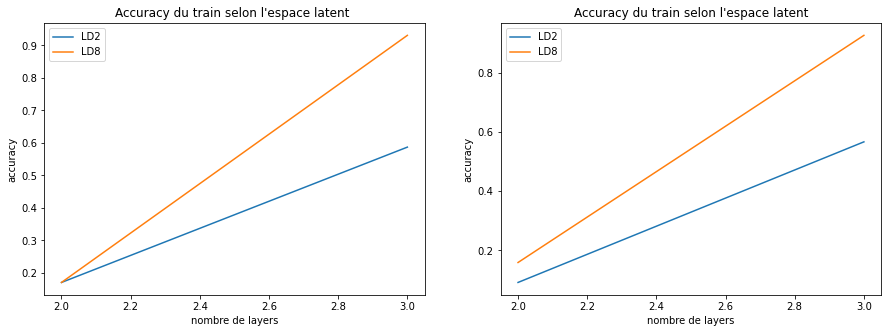

100%|███████████████████████████████████████████| 50/50 [01:08<00:00,  1.38s/it]

Auto encodeur optimal : 
Nombre layer optimal :  3
Dimension optimale de l'espace latent :  8
Fonctions d'activation prises :  ['[<modules.ModuleTanH object at 0x7f9f2f0143a0>\n <modules.ModuleSigmoide object at 0x7f9f2f014160>\n <modules.ModuleTanH object at 0x7f9f2f0143a0>]', '[<modules.ModuleTanH object at 0x7f9f2f0143a0>\n <modules.ModuleTanH object at 0x7f9f2f0143a0>\n <modules.ModuleSigmoide object at 0x7f9f2f014160>]']


In [126]:
liste_layers = np.array([2,3])
liste_dim_espace_latent = np.array([2,8])
batch_size = 50
epochs = 50

auto_encodeur_optimal_rand = optimisation_network(X_train,Y_train,X_test,Y_test,
                                        liste_layers,liste_dim_espace_latent,batch_size,epochs,
                                        random_activ=True,verbose=True)

In [198]:
nb_layer_optimal = len(auto_encodeur_optimal_rand.layers_encodeur) // 2
latent_repre = auto_encodeur_optimal_rand.encode(X_train)
dim_latent_optimale = latent_repre.shape[1]

3

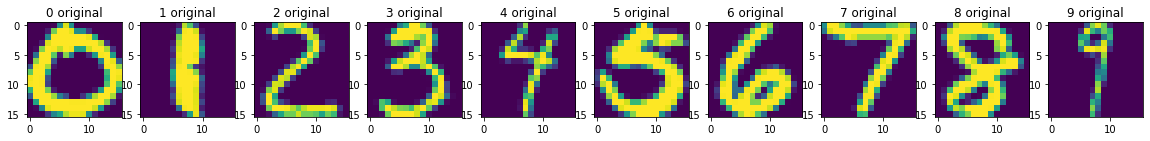

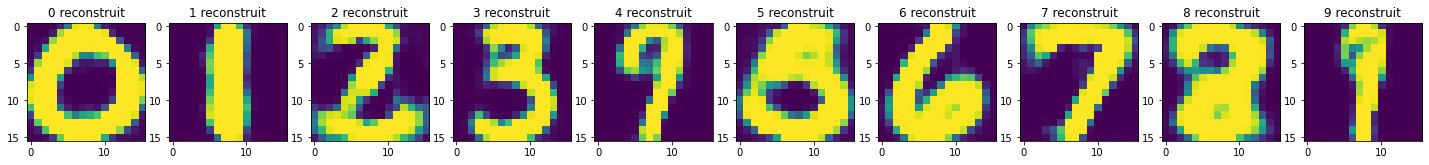

In [123]:
latent_repre = auto_encodeur_optimal_rand.encode(X_train)
X_train_hat = auto_encodeur_optimal_rand.decode(latent_repre)


plt.figure(figsize=(20,15))
sample = np.random.randint(0,100)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_train[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_train_hat[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

### Affichage des données USPS train induites de l'espace latent apres une t-SNE

#### Train

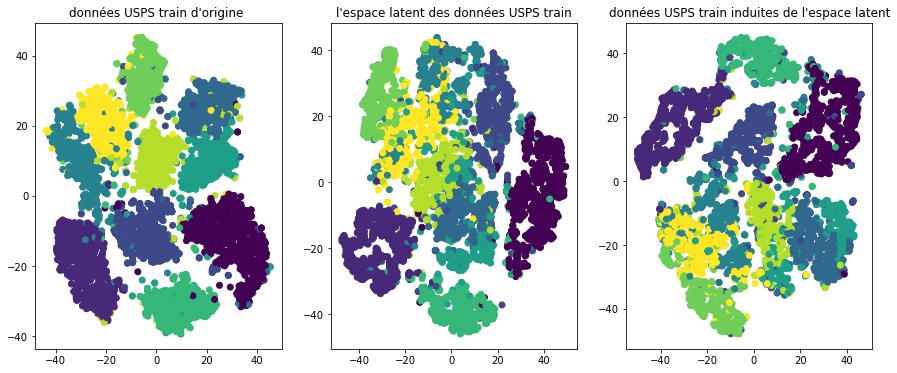

In [131]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)


fig = plt.figure(figsize=(15,6))


plt.subplot(131)
repre_2D = tsne.fit_transform(X_train)
plt.title("données USPS train d'origine ")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)

plt.subplot(132)
repre_2D = tsne.fit_transform(latent_repre)
plt.title("l'espace latent des données USPS train")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)

plt.subplot(133)
repre_2D = tsne.fit_transform(X_train_hat)
plt.title("données USPS train induites de l'espace latent")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)


plt.show()

#### Test

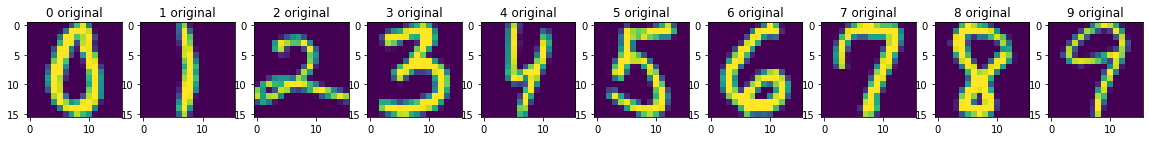

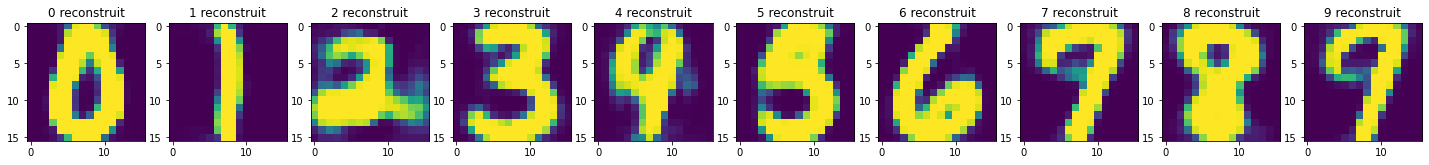

In [188]:
latent_repre_test = auto_encodeur_optimal_rand.encode(X_test)
X_test_hat = auto_encodeur_optimal_rand.decode(latent_repre_test)


plt.figure(figsize=(20,15))
sample = np.random.randint(0,100)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_test[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_test_hat[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

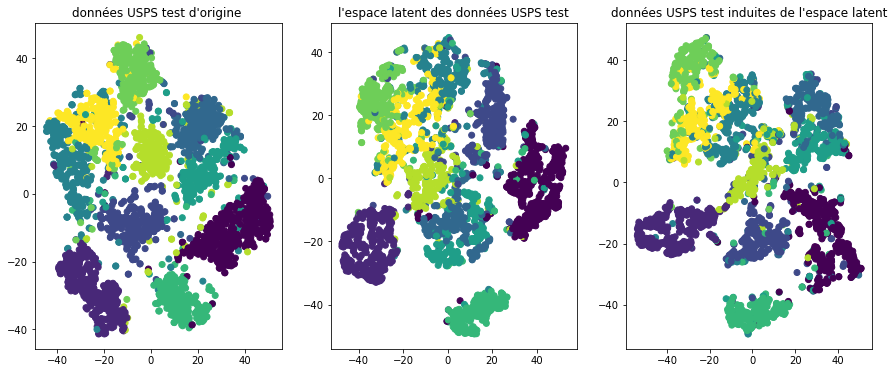

In [189]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)


fig = plt.figure(figsize=(15,6))


plt.subplot(131)
repre_2D = tsne.fit_transform(X_test)
plt.title("données USPS test d'origine ")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_test)

plt.subplot(132)
repre_2D = tsne.fit_transform(latent_repre_test)
plt.title("l'espace latent des données USPS test")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_test)

plt.subplot(133)
repre_2D = tsne.fit_transform(X_test_hat)
plt.title("données USPS test induites de l'espace latent")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_test)


plt.show()

### Evaluation de l'espace latent sur un reseau de neurones multi-classe

#### Train

In [194]:
datas = [X_train,latent_repre,X_train_hat]
evaluation(datas,Y_train,verbose=True)

Optimisation de :  X


100%|███████████████████████████████████████████| 50/50 [00:23<00:00,  2.10it/s]


Accuracy sur les images issues de l'auto encodeur 0.9979129876384653
Pureté du clustering :  0.7068550329105795
Rand score  :  0.9131695728218426
Adjusted Rand Score :  0.5448117147373678

Optimisation de :  Representation Latente


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 37.63it/s]


Accuracy sur les images issues de l'auto encodeur 0.5734467811847809
Pureté du clustering :  0.5803499759190881
Rand score  :  0.8876895347171893
Adjusted Rand Score :  0.41812821235437825

Optimisation de :  X_hat


100%|███████████████████████████████████████████| 50/50 [00:23<00:00,  2.13it/s]


Accuracy sur les images issues de l'auto encodeur 0.6346122973189918
Pureté du clustering :  0.5798683576818109
Rand score  :  0.8879883421784672
Adjusted Rand Score :  0.4193406453584548



([0.9979129876384653, 0.5734467811847809, 0.6346122973189918],
 [0.7068550329105795, 0.5803499759190881, 0.5798683576818109],
 [0.9131695728218426, 0.8876895347171893, 0.8879883421784672])

#### Test

In [195]:
datas = [X_test,latent_repre_test,X_test_hat]
evaluation(datas,Y_test,verbose=True)

Optimisation de :  X


100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.08it/s]


Accuracy sur les images issues de l'auto encodeur 0.996415770609319
Pureté du clustering :  0.7057673509286413
Rand score  :  0.9126345679106751
Adjusted Rand Score :  0.5352113414664057

Optimisation de :  Representation Latente


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 79.66it/s]


Accuracy sur les images issues de l'auto encodeur 0.6630824372759857
Pureté du clustering :  0.7064190289996741
Rand score  :  0.914118473713881
Adjusted Rand Score :  0.5431277605888701

Optimisation de :  X_hat


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.99it/s]


Accuracy sur les images issues de l'auto encodeur 0.9146301726946888
Pureté du clustering :  0.7217334636689475
Rand score  :  0.9169966477238211
Adjusted Rand Score :  0.5576688761924068



([0.996415770609319, 0.6630824372759857, 0.9146301726946888],
 [0.7057673509286413, 0.7064190289996741, 0.7217334636689475],
 [0.9126345679106751, 0.914118473713881, 0.9169966477238211])

### PCA sur l'espace latent appris par reseau

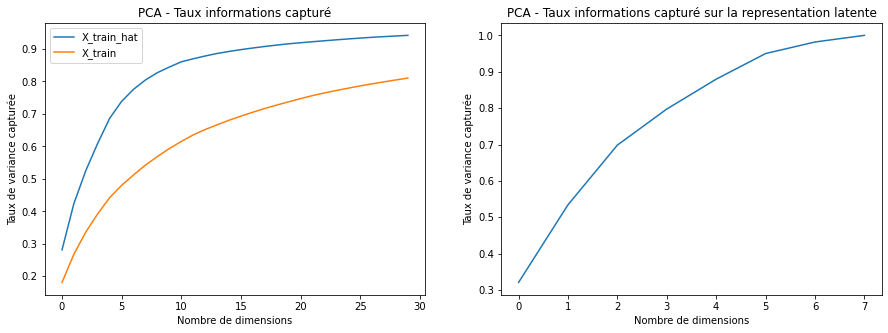

La quantité d'information moyenne perdue pendant le decodage :  0.02841758640429075


In [136]:
pca_1 = PCA(n_components=30,random_state=96)
pca_1.fit(X_train_hat)

pca_2 = PCA(n_components=30,random_state=96)
pca_2.fit(X_train)

pca_3 = PCA(n_components=dim_latent_optimale,random_state=96)
pca_3.fit(latent_repre)


plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(np.cumsum(pca_1.explained_variance_ratio_))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_))
plt.legend(["X_train_hat","X_train"])
plt.title("PCA - Taux informations capturé")
plt.xlabel("Nombre de dimensions")
plt.ylabel("Taux de variance capturée")


plt.subplot(122)
plt.plot(np.cumsum(pca_3.explained_variance_ratio_))
plt.title("PCA - Taux informations capturé sur la representation latente")
plt.xlabel("Nombre de dimensions")
plt.ylabel("Taux de variance capturée")

plt.show()

quantite_info_apres_decodage = pca_1.explained_variance_ratio_[:8]
quantite_info_espace_latent = pca_3.explained_variance_ratio_
print("La quantité d'information moyenne perdue pendant le decodage : ",
      np.abs( quantite_info_apres_decodage - quantite_info_espace_latent ).mean())

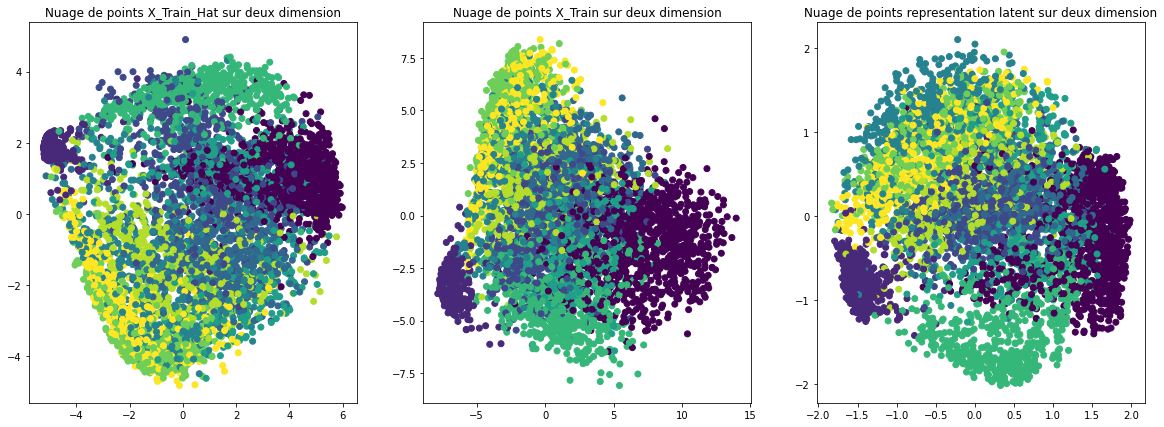

In [138]:
X_train_hat_pca = pca_1.transform(X_train_hat)
X_train_pca = pca_2.transform(X_train)
latent_repre_pca = pca_3.transform(latent_repre)

plt.figure(figsize=(20,7))

plt.subplot(131)
plt.scatter(X_train_hat_pca[:,0],X_train_hat_pca[:,1],c=Y_train)
plt.title("Nuage de points X_Train_Hat sur deux dimension")

plt.subplot(132)
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=Y_train)
plt.title("Nuage de points X_Train sur deux dimension")

plt.subplot(133)
plt.scatter(latent_repre_pca[:,0],latent_repre_pca[:,1],c=Y_train)
plt.title("Nuage de points representation latent sur deux dimension")


plt.show()

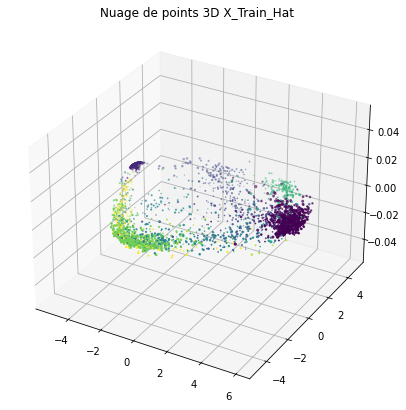

In [149]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(projection='3d')

plt.title("Nuage de points 3D X_Train_Hat")
plt.scatter(X_train_hat_pca[:,0],X_train_hat_pca[:,1],X_train_hat_pca[:,2],c=Y_train)
plt.show()

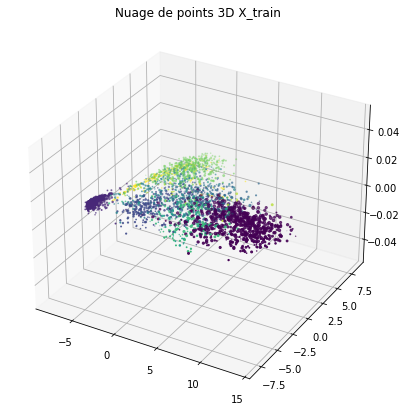

In [150]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(projection='3d')

plt.title("Nuage de points 3D X_train")
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],X_train_pca[:,2],c=Y_train)
plt.show()

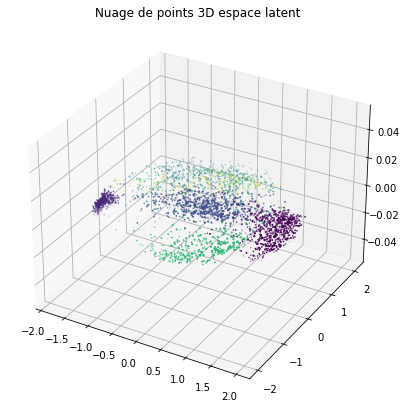

In [151]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(projection='3d')

plt.title("Nuage de points 3D espace latent")
plt.scatter(latent_repre_pca[:,0],latent_repre_pca[:,1],latent_repre_pca[:,2],c=Y_train)
plt.show()

### Impact du batch sur l'apprentissage de l'espace latent

In [185]:
shape = X_train.shape[1]
nb_layers = nb_layer_optimal
output_dim = dim_latent_optimale

size = len(auto_encodeur_optimal_rand.layers_encodeur)
auto_encodeur_optimal_rand.layers_encodeur = np.array(auto_encodeur_optimal_rand.layers_encodeur)
indices = [i for i in range(size) if i % 2 == 1 ]
activ_enc = auto_encodeur_optimal_rand.layers_encodeur[indices]

auto_encodeur_optimal_rand.layers_decodeur = np.array(auto_encodeur_optimal_rand.layers_decodeur)
indices = [i for i in range(size) if i % 2 == 1 ]
activ_dec = list(auto_encodeur_optimal_rand.layers_decodeur[indices])

activations = [ activ_enc , activ_dec]

facteur_norma = 0.8
plage_biais = (0,1)
epochs = 50
liste_batch_size = [50,300,500]
liste_auto_encodeurs = []

for batch_size in liste_batch_size:

    liste_auto_encodeurs.append(create_auto_encodeur(X_train,output_dim, nb_layers,activations, 
                                                 facteur_norma, plage_biais, batch_size, epochs,eps=1e-4))

100%|███████████████████████████████████████████| 50/50 [00:52<00:00,  1.06s/it]


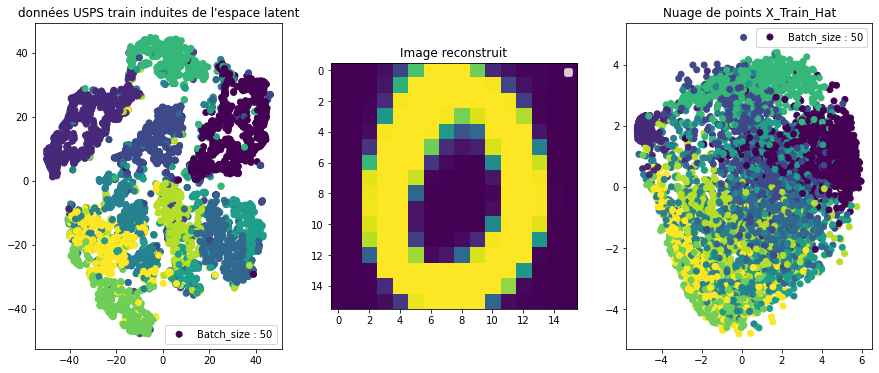

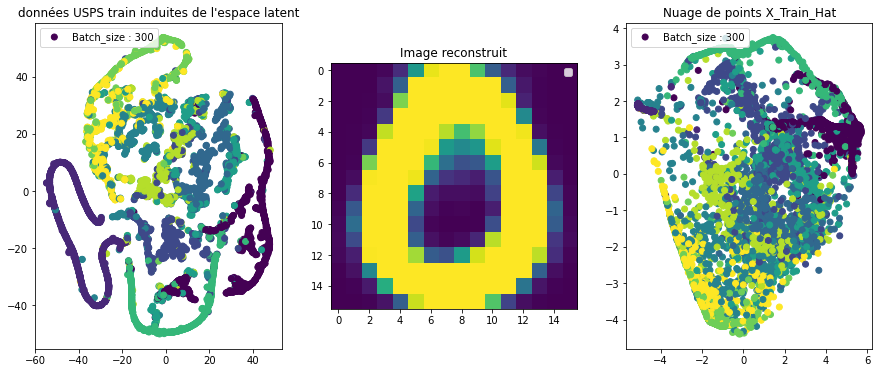

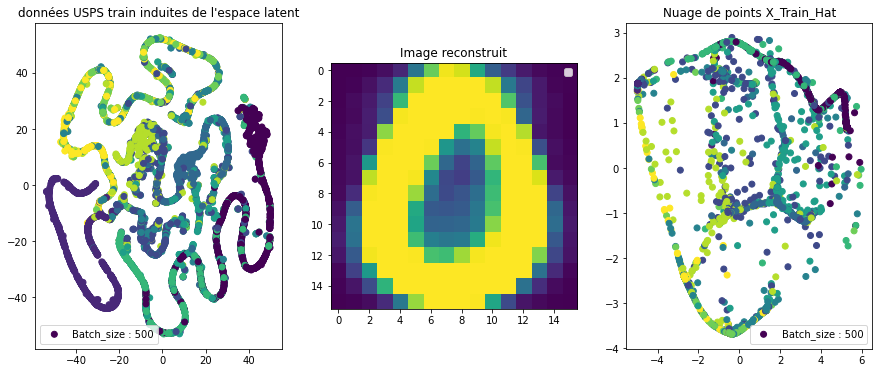

In [282]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)

for i,auto_encodeur in enumerate(liste_auto_encodeurs):
    
    latent_repre = auto_encodeur.encode(X_train)
    X_train_hat = auto_encodeur.decode(latent_repre)
    
    X_train_hat_pca = pca_1.transform(X_train_hat)
    

    fig = plt.figure(figsize=(15,6))


    plt.subplot(1,3,1)
    repre_2D = tsne.fit_transform(X_train_hat)
    plt.title("données USPS train induites de l'espace latent")
    plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)
    plt.legend(["Batch_size : "+str(liste_batch_size[i])])
    
    plt.subplot(1,3,2)
    plt.title("Image reconstruit")
    image = X_train_hat[Y_train == 0][27].reshape((16,16))
    plt.imshow(image)
    plt.legend(["Batch_size : "+str(liste_batch_size[i])])
    
    
    plt.subplot(1,3,3)
    plt.title("Nuage de points X_Train_Hat")
    plt.scatter(X_train_hat_pca[:,0],X_train_hat_pca[:,1],c=Y_train)
    plt.legend(["Batch_size : "+str(liste_batch_size[i])])
    
    plt.show()

#### Fonctions d'activation du reseau d'une maniere deterministe

In [ ]:
liste_layers = np.array([3,4,5,6])
liste_dim_espace_latent = np.array([8,10,12,14])
batch_size = 50
epochs = 50

auto_encodeur_optimal_no_rand = optimisation_network(X_train,Y_train,liste_layers,
                                       liste_dim_espace_latent,batch_size,epochs,
                                       random_activ=False,verbose=True)

In [ ]:
latent_repre = auto_encodeur_optimal_no_rand.encode(X_train)
X_train_hat = auto_encodeur_optimal_no_rand.decode(latent_repre)


plt.figure(figsize=(20,15))
sample = np.random.randint(0,100)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_train[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_train_hat[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

## Debruitage de données

#### Bruit poisson

100%|███████████████████████████████████████████| 50/50 [00:22<00:00,  2.26it/s]


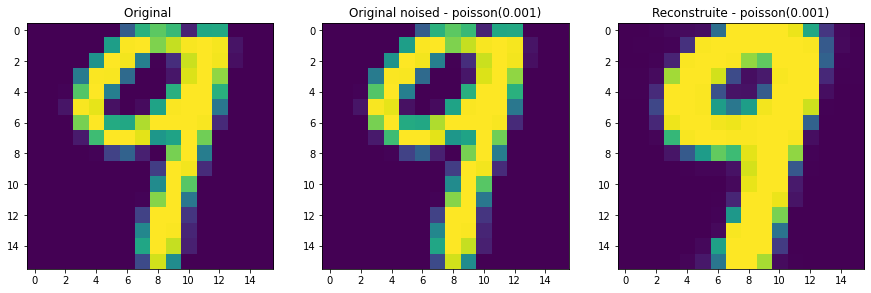

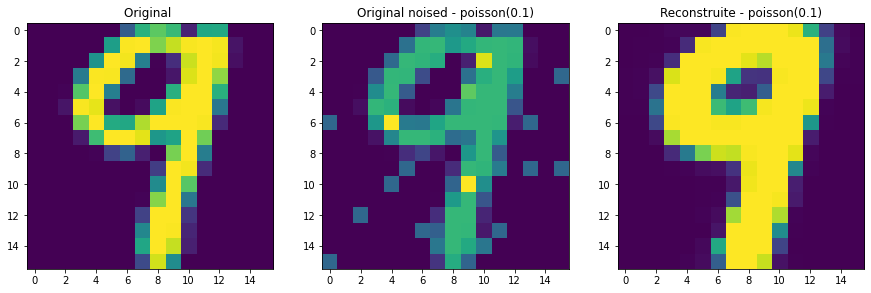

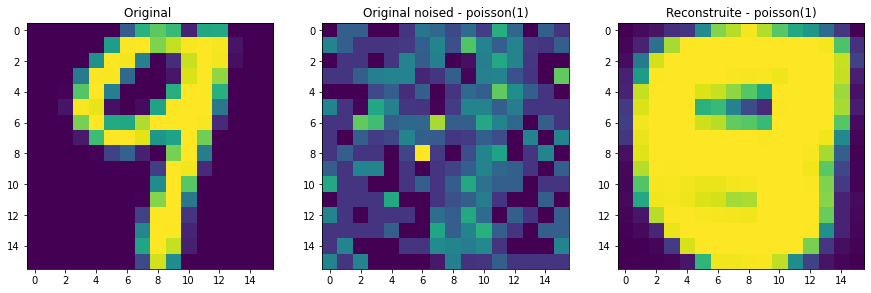

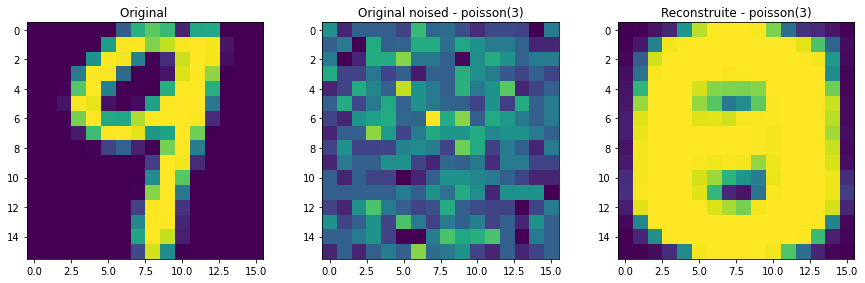

In [306]:
lamdas = [1e-3,1e-1,1,3]
scores = []

for i,lamda in enumerate(lamdas):
    noise = generate_noise(X_train.shape[1],'poisson',lamda,1e-1)
    X_train_noised = X_train + noise
    
    latent_repre_noised = auto_encodeur_optimal_rand.encode(X_train_noised)
    X_train_noised_hat = auto_encodeur_optimal_rand.decode(latent_repre_noised)
    sample = 1
    plt.figure(figsize=(15,20))

    plt.subplot(i+1,3,1)
    plt.title("Original ")
    image = X_train[sample].reshape((16,16))
    plt.imshow(image)


    plt.subplot(i+1,3,2)
    plt.title("Original noised - poisson("+str(lamda)+")")
    image = X_train_noised[sample].reshape((16,16))
    plt.imshow(image)


    plt.subplot(i+1,3,3)
    plt.title("Reconstruite - poisson("+str(lamda)+")")
    image = X_train_noised_hat[sample].reshape((16,16))
    plt.imshow(image)
    
    datas = [X_train_noised,latent_repre_noised,X_train_noised_hat]
    scores.append(evaluation(datas,Y_train,verbose=False)[0][2])
    
plt.show()

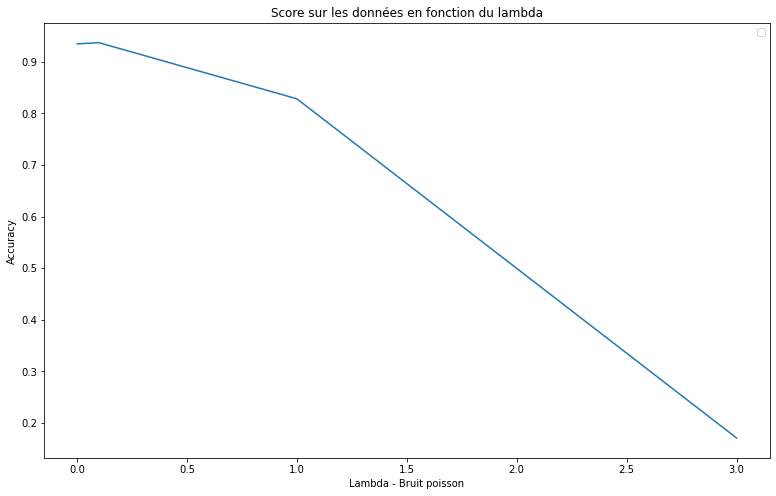

In [308]:
plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction du lambda")
plt.xlabel("Lambda - Bruit poisson")
plt.ylabel("Accuracy")
plt.legend(["Train"])
plt.plot(lamdas,scores)
plt.show()

#### Bruit gaussien

100%|███████████████████████████████████████████| 50/50 [00:23<00:00,  2.16it/s]


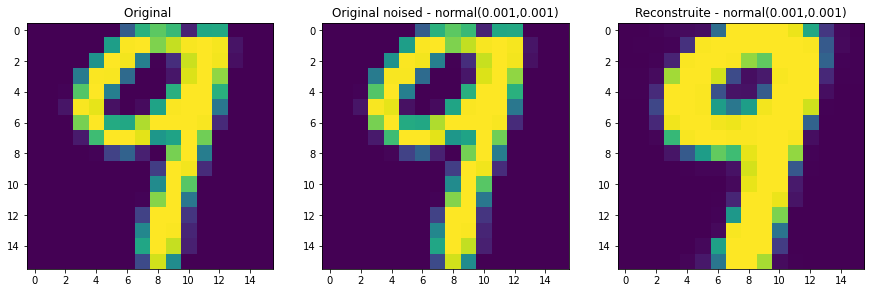

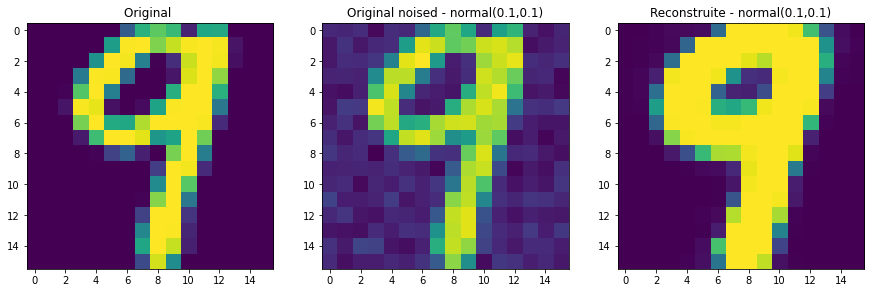

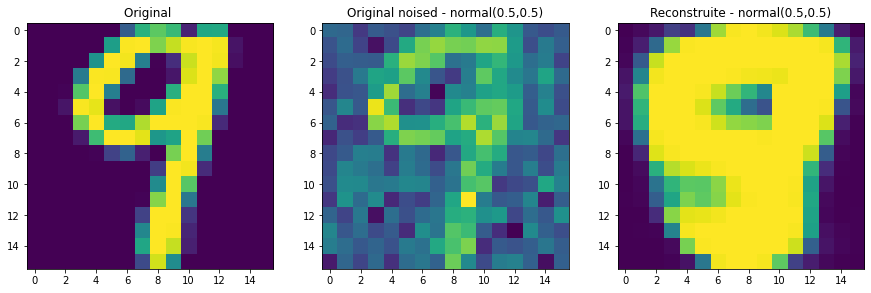

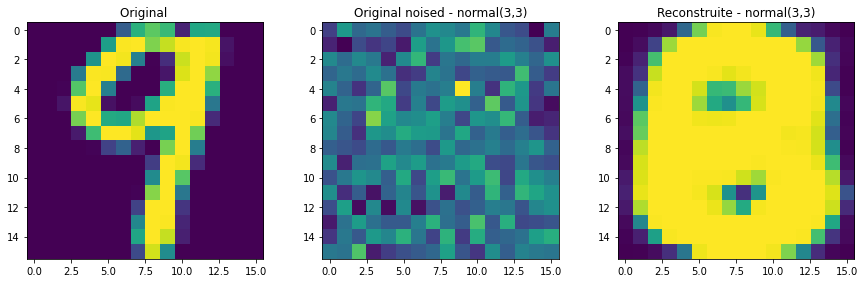

In [309]:
means = [1e-3,1e-1,0.5,3]
stds = [1e-3,1e-1,0.5,3]
scores = []


for i,mean in enumerate(means):
    noise = generate_noise(X_train.shape[1],'gaussien',mean,stds[i])
    X_train_noised = X_train + noise
    
    latent_repre_noised = auto_encodeur_optimal_rand.encode(X_train_noised)
    X_train_noised_hat = auto_encodeur_optimal_rand.decode(latent_repre_noised)
    sample = 1
    plt.figure(figsize=(15,20))

    plt.subplot(i+1,3,1)
    plt.title("Original ")
    image = X_train[sample].reshape((16,16))
    plt.imshow(image)


    plt.subplot(i+1,3,2)
    plt.title("Original noised - normal("+str(mean)+","+str(stds[i])+")")
    image = X_train_noised[sample].reshape((16,16))
    plt.imshow(image)


    plt.subplot(i+1,3,3)
    plt.title("Reconstruite - normal("+str(mean)+","+str(stds[i])+")")
    image = X_train_noised_hat[sample].reshape((16,16))
    plt.imshow(image)
    
    datas = [X_train_noised,latent_repre_noised,X_train_noised_hat]
    scores.append(evaluation(datas,Y_train,verbose=False)[0][2])
    
    
plt.show()

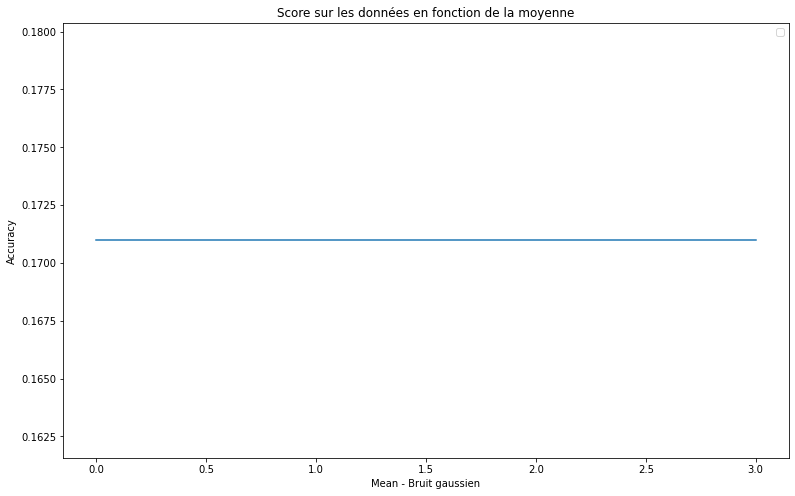

In [311]:
plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction de la moyenne")
plt.xlabel("Mean - Bruit gaussien")
plt.ylabel("Accuracy")
plt.legend(["Train"])
plt.plot(means,scores)
plt.show()

#### Train

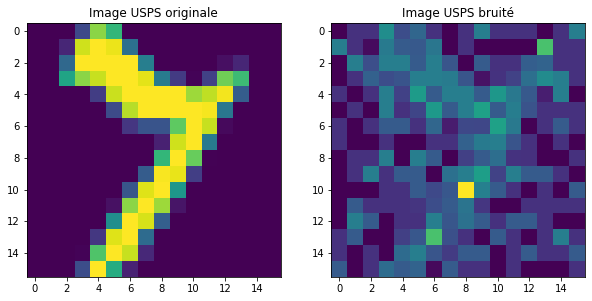

In [298]:
noise = generate_noise(X_train.shape[1],'poisson',1,1e-1)
X_train_noised = X_train + noise

plt.figure(figsize=(10,6))

plt.subplot(121)
plt.title("Image USPS originale")
plt.imshow(X_train[10].reshape((16,16)))

plt.subplot(122)
plt.title("Image USPS bruité")
plt.imshow(X_train_noised[10].reshape((16,16)))
plt.show()

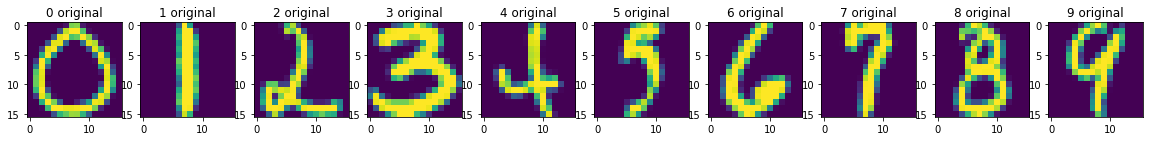

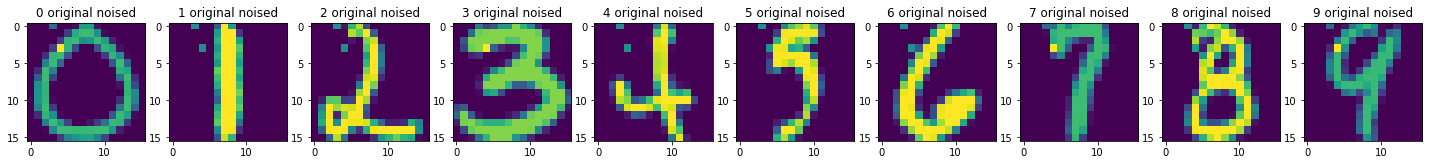

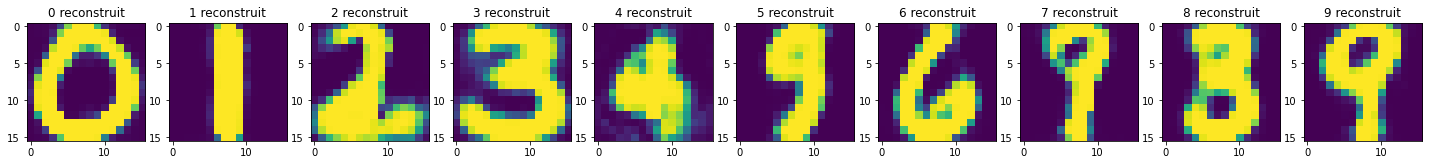

In [272]:
plt.figure(figsize=(20,15))
sample = np.random.randint(0,50)

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_train[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original noised")
    image = X_train_noised[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_train_noised_hat[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

In [253]:
datas = [X_train_noised,latent_repre_noised,X_train_noised_hat]
evaluation(datas,Y_train,verbose=True)

Optimisation de :  X


100%|███████████████████████████████████████████| 50/50 [00:16<00:00,  3.05it/s]


Accuracy sur les images issues de l'auto encodeur 0.9988762241130198
Pureté du clustering :  0.7068550329105795
Rand score  :  0.9131695728218426
Adjusted Rand Score :  0.5448117147373678

Optimisation de :  Representation Latente


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 39.71it/s]


Accuracy sur les images issues de l'auto encodeur 0.7132766094076096
Pureté du clustering :  0.6973832075774603
Rand score  :  0.9127179590604908
Adjusted Rand Score :  0.5422720782095797

Optimisation de :  X_hat


100%|███████████████████████████████████████████| 50/50 [00:19<00:00,  2.56it/s]


Accuracy sur les images issues de l'auto encodeur 0.9381923262160861
Pureté du clustering :  0.7087815058596886
Rand score  :  0.9162529709328804
Adjusted Rand Score :  0.5593187259788213



([0.9988762241130198, 0.7132766094076096, 0.9381923262160861],
 [0.7068550329105795, 0.6973832075774603, 0.7087815058596886],
 [0.9131695728218426, 0.9127179590604908, 0.9162529709328804])

#### Test

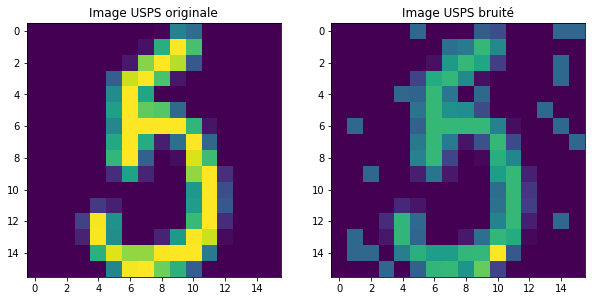

In [263]:
noise = generate_noise(X_test.shape[1],'poisson',1e-1,1e-1)
X_test_noised = X_test + noise

plt.figure(figsize=(10,6))

plt.subplot(121)
plt.title("Image USPS originale")
plt.imshow(X_test[10].reshape((16,16)))

plt.subplot(122)
plt.title("Image USPS bruité")
plt.imshow(X_test_noised[10].reshape((16,16)))
plt.show()

In [264]:
latent_repre_noised = auto_encodeur_optimal_rand.encode(X_test_noised)
X_test_noised_hat = auto_encodeur_optimal_rand.decode(latent_repre_noised)

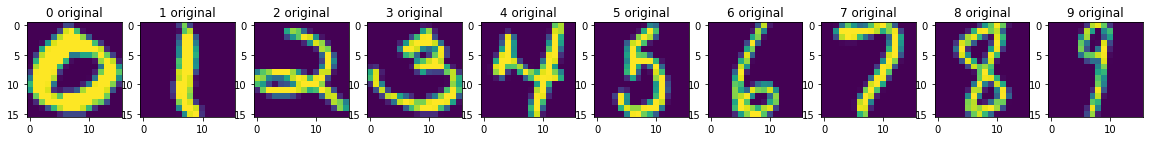

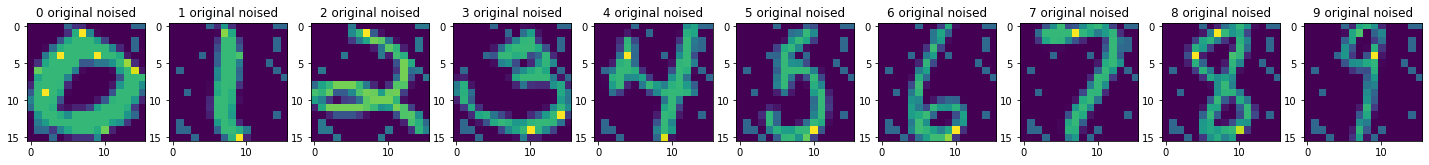

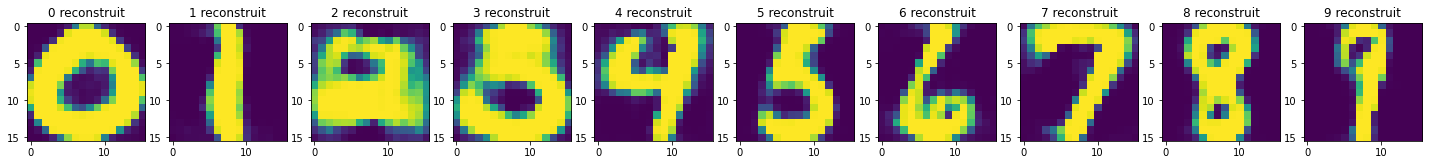

In [265]:
plt.figure(figsize=(20,15))
sample = np.random.randint(0,50)

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_test[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original noised")
    image = X_test_noised[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_test_noised_hat[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

In [257]:
datas = [X_test_noised,latent_repre_noised,X_test_noised_hat]
evaluation(datas,Y_test,verbose=True)

Optimisation de :  X


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  6.08it/s]


Accuracy sur les images issues de l'auto encodeur 0.9967416096448355
Pureté du clustering :  0.7057673509286413
Rand score  :  0.9126345679106751
Adjusted Rand Score :  0.5352113414664057

Optimisation de :  Representation Latente


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 86.99it/s]


Accuracy sur les images issues de l'auto encodeur 0.6409253828608668
Pureté du clustering :  0.6800260671228413
Rand score  :  0.9123168005070684
Adjusted Rand Score :  0.5332557089133871

Optimisation de :  X_hat


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.86it/s]


Accuracy sur les images issues de l'auto encodeur 0.9143043336591724
Pureté du clustering :  0.7295536005213424
Rand score  :  0.9195664004302605
Adjusted Rand Score :  0.5705414443050225



([0.9967416096448355, 0.6409253828608668, 0.9143043336591724],
 [0.7057673509286413, 0.6800260671228413, 0.7295536005213424],
 [0.9126345679106751, 0.9123168005070684, 0.9195664004302605])

In [261]:
shape = X_train.shape[1]
nb_layers = 7
output_dim = 2

TanH = ModuleTanH()
sig = ModuleSigmoide()
activ_enc = [TanH for _ in range(7)]
activ_dec = [TanH for _ in range(6)]
activ_dec.append(sig)

activations = [activ_enc , activ_dec]


facteur_norma = 0.8
plage_biais = (0,1)
batch_size = 50
epochs = 100

AE = create_auto_encodeur(X_train,output_dim, nb_layers,activations, 
                                                 facteur_norma, plage_biais, batch_size, epochs,eps=1e-4)


100%|█████████████████████████████████████████| 100/100 [02:57<00:00,  1.78s/it]


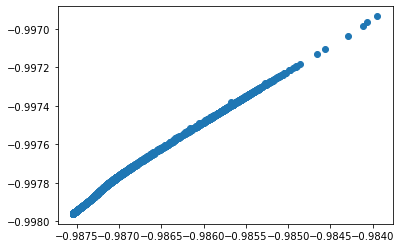

In [262]:
latent_repre = AE.encode(X_train)
plt.scatter(latent_repre[:,0],latent_repre[:,1])
plt.show()

## Wine et classification sur l'espace latent

In [324]:
from sklearn.datasets import load_wine
data = load_wine()
labels = data.target

data_norm = normalisation(data.data)

In [357]:
output_dim = 3
nb_layers = 2
TanH = ModuleTanH()
sig = ModuleSigmoide()
activ_enc = [TanH for _ in range(2)]
activ_dec = [TanH for _ in range(1)]
activ_dec.append(sig)

activations = [activ_enc , activ_dec]

facteur_norma = 0.8
plage_biais = (0,1)
batch_size = 50
epochs = 100


wine_auto_encodeur = create_auto_encodeur(data_norm,output_dim, nb_layers,activations, 
                                                 facteur_norma, plage_biais, batch_size, epochs,eps=1e-4)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 560.85it/s]


In [361]:
latent_repre = wine_auto_encodeur.encode(data_norm)


from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(latent_repre,labels)
print(clf.score(latent_repre,labels))


kmeans = KMeans(n_clusters=3, random_state=0, max_iter=100).fit(latent_repre)
yhat = kmeans.labels_

print(cluster_purity(yhat,labels))

0.7921348314606742
0.7584269662921348


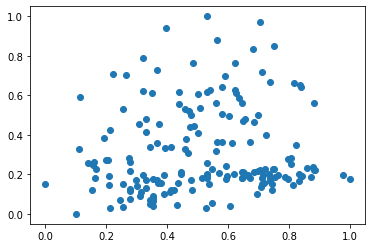

In [362]:
plt.scatter(data_norm[:,0],data_norm[:,1])

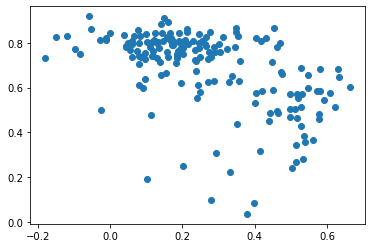

In [363]:
plt.scatter(latent_repre[:,0],latent_repre[:,1])

## Credit Card et clustering sur l'espace latente

In [ ]:
cc_data = pd.read_csv("data/CC GENERAL.csv")

In [ ]:
cc_data.describe()

In [ ]:
# supprimer les valeurs NaN
cc_data = cc_data.dropna()

cc_data = np.array(cc_data)
# supprimer la colonne 1
cc_data = cc_data[:,1:]
cc_data = cc_data.astype('float')
y = np.random.randint(0,1,cc_data.shape[0])

data_norm = normalisation(cc_data)

data_norm = data_norm.astype('float')

In [ ]:
liste_layers = np.array([2,3])
liste_dim_espace_latent = np.array([2,8])
batch_size = 50
epochs = 50

cc_auto_encodeur_optimal = optimisation_network(data_norm,Y_train,X_test,Y_test,
                                        liste_layers,liste_dim_espace_latent,batch_size,epochs,
                                        random_activ=True,verbose=True)

## Alphabets 

In [2]:
import pandas as pd

letters_data = pd.read_csv("data/digital_letters.csv")

In [3]:
letters_data = np.array(letters_data)
letters_labels = letters_data[:,-1]
letters_data = letters_data[:,1:-1]

caracteres = np.unique(letters_labels)
letters_data_bis = []
letters_labels_bis = []
for cara in caracteres:
    letters_data_bis.extend(letters_data[letters_labels == cara][:300])
    letters_labels_bis.extend(letters_labels[letters_labels == cara][:300])
    
letters_data = np.array(letters_data_bis)
letters_labels = np.array(letters_labels_bis)

X_train_letters = letters_data[:5000]
Y_train_letters = letters_labels[:5000]
X_test_letters = letters_data[5000:]
Y_test_letters = letters_labels[5000:]


In [4]:
noise = generate_noise(X_train_letters.shape[1],'normal',1e-1,1e-1)
X_train_letters = X_train_letters.astype('float')
X_train_letters_noised = X_train_letters + noise
print(X_train_letters_noised.shape)

(5000, 784)


In [5]:
noise = generate_noise(X_test_letters.shape[1],'normal',1e-1,1e-1)
X_test_letters = X_test_letters.astype('float')
X_test_letters_noised = X_test_letters + noise
print(X_test_letters_noised.shape)

(2800, 784)


In [6]:
X_test_letters_norm = normalisation(X_test_letters)
X_test_letters_norm_noised = X_test_letters_norm + noise

In [7]:
X_train_letters_norm = normalisation(X_train_letters)
X_train_letters_norm_noised = X_train_letters_norm + noise

plt.imshow(letters_data_norm[0].reshape((28,28)))
plt.show()
plt.imshow(letters_data_norm_noised[0].reshape((28,28)))
plt.show()


NameError: name 'letters_data_norm' is not defined

In [ ]:
shape = X_train_letters_norm.shape[1]
nb_layers = 11
output_dim = 60

TanH = ModuleTanH()
sig = ModuleSigmoide()
activ_enc = [TanH for _ in range(nb_layers)]
activ_dec = [TanH for _ in range(nb_layers-1)]
activ_dec.append(sig)

activations = [activ_enc , activ_dec]


facteur_norma = 0.8
plage_biais = (0,1)
batch_size = 50
epochs = 100

AE = create_auto_encodeur(X_train_letters_norm,output_dim, nb_layers,activations, 
                                                 facteur_norma, plage_biais, batch_size, epochs,eps=1e-4)

 99%|█████████████████████████████████████████▌| 99/100 [08:58<00:05,  5.29s/it]

In [17]:
latent_repre_noised = AE.encode(X_train_letters_norm_noised)
X_train_letters_norm_noised_hat = AE.decode(latent_repre_noised)

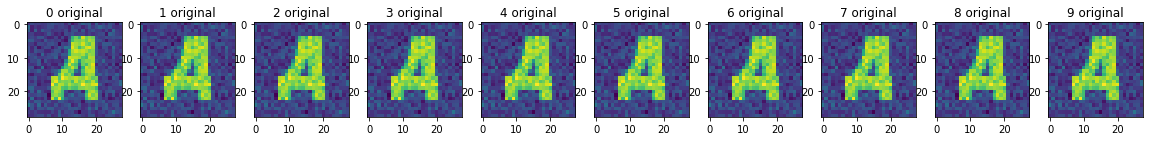

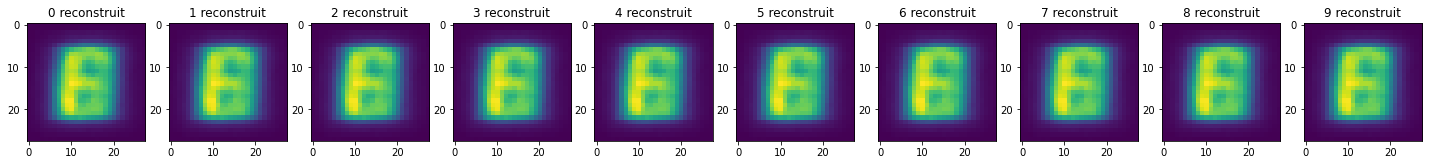

In [18]:
plt.figure(figsize=(20,15))
sample = np.random.randint(0,100)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_train_letters_norm_noised[Y_train_letters == caracteres[i]][sample].reshape((28,28))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_train_letters_norm_noised_hat[Y_train_letters == caracteres[i]][sample].reshape((28,28))
    plt.imshow(image)
plt.show()